In [240]:
import pandas as pd
import numpy as np
import sympy as sp
import math

import matplotlib.pyplot as plt

from autograd import jacobian

In [241]:
range_m = np.array([4.711, 32.787, 36.619, 47.456, 68.986, 80.409])
alpha = np.array([96.024041, 95.302806, 90.571994, 89.747596, 89.333712, 90.014308])
phi = np.array([209.494500, 12.044494, 292.073653, 338.008476, 27.885113, 2.606140])
utmx = np.array([269958.38, 269994.92, 269973.56, 270005.04, 270026.11, 270043.03])
utmy = np.array([3289284.92, 3289291.58, 3289251.91, 3289265.51, 3289313.99, 3289283.87])
utmz = np.array([-13.83, -17.02, -13.83, -13.83, -13.70, -14.85])

df = pd.DataFrame({'range': range_m, 'alpha': alpha, 'phi': phi, 'UTM X': utmx, 'UTM Y': utmy, 'UTM Z': utmz})
change_amounts = np.array([0.106, 0.106, 0.106, 0.106, 0.106, 0.056])
df['UTM Z'] = df['UTM Z'] - change_amounts


df

,range,alpha,phi,UTM X,UTM Y,UTM Z
0,4.711,96.024041,209.494500,269958.38,3289284.92,-13.936
1,32.787,95.302806,12.044494,269994.92,3289291.58,-17.126
2,36.619,90.571994,292.073653,269973.56,3289251.91,-13.936
3,47.456,89.747596,338.008476,270005.04,3289265.51,-13.936
4,68.986,89.333712,27.885113,270026.11,3289313.99,-13.806
5,80.409,90.014308,2.606140,270043.03,3289283.87,-14.906


In [242]:
df['X Body'] = np.NaN; df['Y Body'] = np.NaN; df['Z Body'] = np.NaN

for x in range(df.shape[0]):
    x_body = df['range'][x] * math.cos(np.deg2rad(90 - df['alpha'][x])) * math.cos(np.deg2rad(df['phi'][x])); df['X Body'][x] = x_body
    y_body = df['range'][x] * math.cos(np.deg2rad(90 - df['alpha'][x])) * math.sin(np.deg2rad(df['phi'][x])); df['Y Body'][x] = y_body
    z_body = df['range'][x] * math.sin(np.deg2rad(90 - df['alpha'][x])); df['Z Body'][x] = z_body
    
df

,range,alpha,phi,UTM X,UTM Y,UTM Z,X Body,Y Body,Z Body
0,4.711,96.024041,209.494500,269958.38,3289284.92,-13.936,-4.077825,-2.306606,-0.494399
1,32.787,95.302806,12.044494,269994.92,3289291.58,-17.126,31.927988,6.812422,-3.030153
2,36.619,90.571994,292.073653,269973.56,3289251.91,-13.936,13.760667,-33.933193,-0.365568
3,47.456,89.747596,338.008476,270005.04,3289265.51,-13.936,44.002639,-17.770649,0.209056
4,68.986,89.333712,27.885113,270026.11,3289313.99,-13.806,60.971718,32.262582,0.802215
5,80.409,90.014308,2.606140,270043.03,3289283.87,-14.906,80.325831,3.656200,-0.020080


In [243]:
body_coords = df[['X Body', 'Y Body', 'Z Body']]
utm_coords = df[['UTM X', 'UTM Y', 'UTM Z']]
print(utm_coords)

       UTM X       UTM Y   UTM Z
0  269958.38  3289284.92 -13.936
1  269994.92  3289291.58 -17.126
2  269973.56  3289251.91 -13.936
3  270005.04  3289265.51 -13.936
4  270026.11  3289313.99 -13.806
5  270043.03  3289283.87 -14.906


In [244]:
tx, ty, tz, ex, ey, ez = sp.symbols('Tx Ty Tz Ex Ey Ez')
xb, yb, zb = sp.symbols('xB yB zB')

Rx = sp.Matrix([[1, 0, 0], [0, sp.cos(ex), sp.sin(ex)], [0, -sp.sin(ex), sp.cos(ex)]]);
Ry = sp.Matrix([[sp.cos(ey), 0, -sp.sin(ey)], [0, 1, 0], [sp.sin(ey), 0, sp.cos(ey)]]);
Rz = sp.Matrix([[sp.cos(ez), sp.sin(ez), 0], [-sp.sin(ez), sp.cos(ez), 0], [0, 0, 1]])

R = Rx*Ry*Rz
r_global = sp.Matrix([tx, ty, tz]) + R * sp.Matrix([xb, yb, zb])
A = r_global.jacobian([tx, ty, tz, ex, ey, ez])

In [245]:
Rx

Matrix([
[1,        0,       0],
[0,  cos(Ex), sin(Ex)],
[0, -sin(Ex), cos(Ex)]])

In [246]:
Ry

Matrix([
[cos(Ey), 0, -sin(Ey)],
[      0, 1,        0],
[sin(Ey), 0,  cos(Ey)]])

In [247]:
Rz

Matrix([
[ cos(Ez), sin(Ez), 0],
[-sin(Ez), cos(Ez), 0],
[       0,       0, 1]])

In [248]:
R

Matrix([
[                          cos(Ey)*cos(Ez),                            sin(Ez)*cos(Ey),        -sin(Ey)],
[sin(Ex)*sin(Ey)*cos(Ez) - sin(Ez)*cos(Ex),  sin(Ex)*sin(Ey)*sin(Ez) + cos(Ex)*cos(Ez), sin(Ex)*cos(Ey)],
[sin(Ex)*sin(Ez) + sin(Ey)*cos(Ex)*cos(Ez), -sin(Ex)*cos(Ez) + sin(Ey)*sin(Ez)*cos(Ex), cos(Ex)*cos(Ey)]])

In [249]:
r_global

Matrix([
[                                                                 Tx + xB*cos(Ey)*cos(Ez) + yB*sin(Ez)*cos(Ey) - zB*sin(Ey)],
[ Ty + xB*(sin(Ex)*sin(Ey)*cos(Ez) - sin(Ez)*cos(Ex)) + yB*(sin(Ex)*sin(Ey)*sin(Ez) + cos(Ex)*cos(Ez)) + zB*sin(Ex)*cos(Ey)],
[Tz + xB*(sin(Ex)*sin(Ez) + sin(Ey)*cos(Ex)*cos(Ez)) + yB*(-sin(Ex)*cos(Ez) + sin(Ey)*sin(Ez)*cos(Ex)) + zB*cos(Ex)*cos(Ey)]])

In [250]:
A

Matrix([
[1, 0, 0,                                                                                                                      0,                        -xB*sin(Ey)*cos(Ez) - yB*sin(Ey)*sin(Ez) - zB*cos(Ey),                                                         -xB*sin(Ez)*cos(Ey) + yB*cos(Ey)*cos(Ez)],
[0, 1, 0,  xB*(sin(Ex)*sin(Ez) + sin(Ey)*cos(Ex)*cos(Ez)) + yB*(-sin(Ex)*cos(Ez) + sin(Ey)*sin(Ez)*cos(Ex)) + zB*cos(Ex)*cos(Ey), xB*sin(Ex)*cos(Ey)*cos(Ez) + yB*sin(Ex)*sin(Ez)*cos(Ey) - zB*sin(Ex)*sin(Ey), xB*(-sin(Ex)*sin(Ey)*sin(Ez) - cos(Ex)*cos(Ez)) + yB*(sin(Ex)*sin(Ey)*cos(Ez) - sin(Ez)*cos(Ex))],
[0, 0, 1, xB*(-sin(Ex)*sin(Ey)*cos(Ez) + sin(Ez)*cos(Ex)) + yB*(-sin(Ex)*sin(Ey)*sin(Ez) - cos(Ex)*cos(Ez)) - zB*sin(Ex)*cos(Ey), xB*cos(Ex)*cos(Ey)*cos(Ez) + yB*sin(Ez)*cos(Ex)*cos(Ey) - zB*sin(Ey)*cos(Ex),  xB*(sin(Ex)*cos(Ez) - sin(Ey)*sin(Ez)*cos(Ex)) + yB*(sin(Ex)*sin(Ez) + sin(Ey)*cos(Ex)*cos(Ez))]])

In [272]:
t_x = df['UTM X'].mean(); t_y = df['UTM Y'].mean(); t_z = df['UTM Z'].mean()
e1 = 0; e2 = 0; e3 = 0

trans = np.array([t_x, t_y, t_z])
epsi = np.array([e1, e2, e3])
print(f'T array: {trans}')
print(f'Epsilon array: {epsi}')

T array: [ 2.70000173e+05  3.28928196e+06 -1.46076667e+01]
Epsilon array: [0 0 0]


In [252]:
jac_funct = sp.lambdify((tx, ty, tz, ex, ey, ez, xb, yb, zb), A)
r_funct = sp.lambdify((ex, ey, ez), R)

In [253]:
def log_t(x):
    if x>=0:
        return math.log10(x)
    else:
        return -(math.log10(-x))

In [273]:
tx = []
ty = []
tz = []
ex = []
ey = []
ez = []

print(e1)
for x in range(10):
    print(f'iter: {x}')
    j_val = jac_funct(t_x, t_y, t_z, e1, e2, e3, df['X Body'][0], df['Y Body'][0], df['Z Body'][0])
    for y in range(1, df.shape[0]):
        x_iter = df['X Body'][y]
        y_iter = df['Y Body'][y]
        z_iter = df['Z Body'][y]
        
        j_iter = jac_funct(t_x, t_y, t_z, e1, e2, e3, x_iter, y_iter, z_iter)
        j_val = np.vstack((j_val, j_iter))
        
    #print(j_val)
    r = r_funct(e1, e2, e3)    
    res = utm_coords.iloc[0] - ((trans).T + r@np.array(body_coords.iloc[0]))
    print(f'trans: {trans}')
    for z in range(1, df.shape[0]):
        res_val = utm_coords.iloc[z] - ((trans).T + r@np.array(body_coords.iloc[z]))
        res = np.hstack((res, res_val))
        
    print(res)    
    corr = np.linalg.inv(j_val.T @ j_val) @ j_val.T @ res
    t_x += corr[0]; t_y += corr[1]; t_z += corr[2]; e1 += corr[3]; e2 += corr[4]; e3 += corr[5]
    trans = np.array([t_x, t_y, t_z])
    
    tx.append(log_t(t_x)); ty.append(log_t(t_y)); tz.append(log_t(t_z))
    ex.append(e1); ey.append(e2); ez.append(e3)

0
iter: 0
trans: [ 2.70000173e+05  3.28928196e+06 -1.46076667e+01]
[-3.77155080e+01  5.26327253e+00  1.16606610e+00 -3.71813218e+01
  2.80424452e+00  5.11819957e-01 -4.03740007e+01  3.87985921e+00
  1.03723461e+00 -3.91359728e+01  1.31731537e+00  4.62610335e-01
 -3.50350515e+01 -2.35915823e-01 -5.47883652e-04 -3.74691640e+01
 -1.74953373e+00 -2.78253461e-01]
iter: 1
trans: [ 2.69962519e+05  3.28928699e+06 -1.34930852e+01]
[ 0.12375525 -0.10962556 -0.02700485  0.07271616  0.46537595 -0.04304886
  0.15481209 -0.11994814 -0.01237137  0.14924341 -0.11383838 -0.00987475
  0.14453052 -0.08460513  0.04682183  0.17054748 -0.08540821 -0.04806625]
iter: 2
trans: [ 2.69962656e+05  3.28928698e+06 -1.34902616e+01]
[-0.01239531 -0.10080937 -0.02825798 -0.06251571  0.46974777 -0.04223532
  0.01880895 -0.11112882  0.03863051  0.01318375 -0.10488612  0.03081401
  0.00824093 -0.07541418  0.0236633   0.03468734 -0.07763762 -0.02262043]
iter: 3
trans: [ 2.69962656e+05  3.28928698e+06 -1.34903683e+01]
[-0.

In [274]:
print(f'Unknown Parameters:')
print(f'Tx: {t_x}')
print(f'Ty: {t_y}')
print(f'Tz: {t_z}')
print(f'E1: {e1}')
print(f'E2: {e2}')
print(f'E3: {e3}')

Unknown Parameters:
Tx: 269962.6556415791
Ty: 3289286.9813997406
Tz: -13.490367889505684
E1: 0.001953286000383963
E2: -0.01716014599682048
E3: 0.08319021863398897


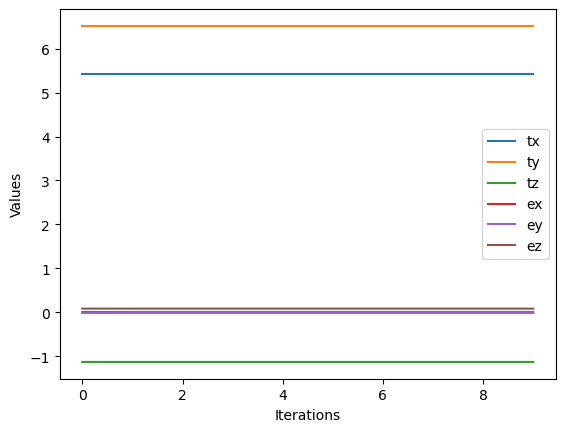

In [313]:
plt.plot(tx, label='tx')
plt.plot(ty, label='ty')
plt.plot(tz, label='tz')
plt.plot(ex, label = 'ex')
plt.plot(ey, label = 'ey')
plt.plot(ez, label = 'ez')

plt.xlabel('Iterations')
plt.ylabel('Values')

plt.legend()
plt.show()

In [294]:
scans = np.load('scan.npy')
scans

array([[ 52.34461094,  86.56997583, -75.47034114,  -5.01      ],
       [ 52.28712485,  86.58486201, -75.47040593,  -5.33      ],
       [ 52.12748354,  86.62889426, -75.47025255,  -5.58      ],
       ...,
       [ 60.85140352,  84.79349493,  38.7228198 , -18.639999  ],
       [ 61.01603995,  84.81866096,  38.50762228, -13.59      ],
       [ 61.2920161 ,  84.79465294,  38.70320062, -17.73      ]])

In [295]:
scans.shape

(1176072, 4)

In [301]:
scans_params = scans[:, :3]
scans_test = scans_params.copy()
scans_intensity = scans[:, 3]
for x in range(scans.shape[0]):
    scans_test[x][0] = scans_params[x][0] * np.cos(np.deg2rad(90 - scans_params[x][1])) * np.cos(np.deg2rad(scans_params[x][2]))
    scans_test[x][1] = scans_params[x][0] * np.cos(np.deg2rad(90 - scans_params[x][1])) * np.sin(np.deg2rad(scans_params[x][2]))
    scans_test[x][2] = scans_params[x][0] * np.sin(np.deg2rad(90 - scans_params[x][1]))
    
scans_params.shape

(1176072, 3)

In [325]:
scans_range = scans[:,0]
scans_alpha = scans[:,1]
scans_phi = scans[:,2]

cart_x = scans_range * np.cos(np.deg2rad(90 - scans_alpha)) * np.cos(np.deg2rad(scans_phi))
cart_y = scans_range * np.cos(np.deg2rad(90 - scans_alpha)) * np.sin(np.deg2rad(scans_phi))
cart_z = scans_range * np.sin(np.deg2rad(90 - scans_alpha))
    
scans_cart = np.array([cart_x, cart_y, cart_z]).T
scans_cart

scans_cart_trans = np.zeros(scans_cart.shape)
for x in range(scans_cart.shape[0]):
    scans_cart_trans[x] = np.array([t_x, t_y, t_z,]) + r@scans_cart[x]
    
print(scans_cart_trans)
scans_cart_trans = np.hstack((scans_cart_trans, scans_intensity[:, None]))

[[ 2.69962601e+05  3.28928698e+06 -1.62930041e+01]
 [ 2.69962601e+05  3.28928698e+06 -1.62871544e+01]
 [ 2.69962601e+05  3.28928698e+06 -1.62710733e+01]
 ...
 [ 2.69964640e+05  3.28928739e+06  3.89254965e+00]
 [ 2.69964661e+05  3.28928740e+06  3.94808149e+00]
 [ 2.69964696e+05  3.28928741e+06  4.07141441e+00]]


array([ -5.01    ,  -5.33    ,  -5.58    , ..., -18.639999, -13.59    ,
       -17.73    ])